# <center> Домашнее задание: Статистические тесты в контексте EDA

## Постановка задачи

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

### В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?<p></p>

3. Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

4. Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

    - тесты для количественного признака:
        - для одной выборки;
        - для двух выборок;
        - для нескольких выборок;
    - тест для категориальных признаков.


## Загрузка данных

In [73]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [74]:
# загружаем датасет
data = pd.read_csv('./ds_salaries.zip')
data

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [75]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [77]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты если необходимо:
if data[data.duplicated()].shape[0] == 0:
    print('Дубликатов не обраружено. Размеры таблицы не меняется: {}'.format(data.shape))
else:
    data = data.drop_duplicates()
    print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Дубликатов не обраружено. Размеры таблицы не меняется: (607, 12)


#### Преобразование признаков

In [78]:
# Удалим первый столбец "Unnamed: 0", который совпадает с индексом
data = data.drop('Unnamed: 0', axis=1)

In [79]:
# work_year сделаем категориальным, поскольку у нас в наличии всего три года
data['work_year'] = data['work_year'].astype('category')

# experience_level является порядковым категориальным признаком (чем больше опыт, тем выше порядок),
# поэтому указываем порядок преобразовании признака в категориальный.
data['experience_level'] = pd.Categorical(data['experience_level'], categories=['EN', 'MI', 'SE', 'EX'], ordered=True)

# employment_type является категориальным, но не порядковам
data['employment_type'] = data['employment_type'].astype('category')

# job_title - используя этот признак, создадим два новых, анализ которых поставлен в задаче:
# 1) is_data_scientist - 1 or 0
# 2) is_data_engineer - 1 or 0
#
# а сам job_title удалим
if 'job_title' in data:
    data['is_data_scientist'] = data['job_title'].apply(lambda x: 1 if x == 'Data Scientist' else 0)
    data['is_data_engineer'] = data['job_title'].apply(lambda x: 1 if x == 'Data Engineer' else 0)
    data = data.drop('job_title', axis=1)
    
# company_size является порядковым категориальным признаком - размер компании можно сравнивать,
# поэтому далем соответствующие преобразования
data['company_size'] = pd.Categorical(data['company_size'], categories=['S', 'M', 'L'], ordered=True)

# признаки salary, salary_currency, employee_residence, company_location и remote_ratio скорее всего, не будут учавствовать в анализе
# исходя из условия задачи, поэтому их можно удалить.
# Но поскольку много места они не занимают и никак не повлияют на статистический анализ,
# то оставим их для поиска какой-нибудь закономерности, выделив из них категориальные признаки remote_ratio, валюты и кода страны
data['salary_currency'] = data['salary_currency'].astype('category')
data['employee_residence'] = data['employee_residence'].astype('category')
data['company_location'] = data['company_location'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')

# итого получаем
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           607 non-null    category
 1   experience_level    607 non-null    category
 2   employment_type     607 non-null    category
 3   salary              607 non-null    int64   
 4   salary_currency     607 non-null    category
 5   salary_in_usd       607 non-null    int64   
 6   employee_residence  607 non-null    category
 7   remote_ratio        607 non-null    category
 8   company_location    607 non-null    category
 9   company_size        607 non-null    category
 10  is_data_scientist   607 non-null    int64   
 11  is_data_engineer    607 non-null    int64   
dtypes: category(8), int64(4)
memory usage: 30.2 KB


#### Статистические характеристики признаков

In [80]:
print("=== Частоты категориальных признаков ===")
display(data['work_year'].value_counts())
display(data['experience_level'].value_counts())
display(data['employment_type'].value_counts())
display(data['salary_currency'].value_counts().head(5))
display(data['company_location'].value_counts().head(5))
display(data['employee_residence'].value_counts().head(5))
display(data['remote_ratio'].value_counts().head(5))
display(data['company_size'].value_counts().head(5))

=== Частоты категориальных признаков ===


work_year
2022    318
2021    217
2020     72
Name: count, dtype: int64

experience_level
SE    280
MI    213
EN     88
EX     26
Name: count, dtype: int64

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

salary_currency
USD    398
EUR     95
GBP     44
INR     27
CAD     18
Name: count, dtype: int64

company_location
US    355
GB     47
CA     30
DE     28
IN     24
Name: count, dtype: int64

employee_residence
US    332
GB     44
IN     30
CA     29
DE     25
Name: count, dtype: int64

remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64

company_size
M    326
L    198
S     83
Name: count, dtype: int64

##### Выводы по категориальным признакам
* с каждым годом число позиций связанные с DS увеличивается
* больше всего требуется DS-специалистов уровня эксперта
* больше всего требуется DS-специалистов в средних компаниях
* интересно, что 
    - 30 позиций из Канады, но только 18 позиций платят зарплату в канадский долларах
    - 24 поизций из Индии, но 27 позиций платят зарплату в индийских рупиях
  
  (возможно, это связано с сотрудниками из других стран)

In [81]:
# проверим компании из Канады, которые платят не в канадских долларах
data[(data['company_location'] == 'CA') & (data['salary_currency'] != 'CAD')]

,work_year,experience_level,employment_type,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,is_data_scientist,is_data_engineer
224,2021,SE,FT,225000,USD,225000,US,100,CA,L,0,0
358,2022,SE,FT,192400,USD,192400,CA,100,CA,M,0,0
359,2022,SE,FT,90700,USD,90700,CA,100,CA,M,0,0
360,2022,SE,FT,130000,USD,130000,CA,100,CA,M,0,0
361,2022,SE,FT,61300,USD,61300,CA,100,CA,M,0,0
362,2022,SE,FT,130000,USD,130000,CA,100,CA,M,0,0
363,2022,SE,FT,61300,USD,61300,CA,100,CA,M,0,0
491,2022,MI,FT,75000,USD,75000,CA,100,CA,S,0,0
530,2022,MI,FT,85000,USD,85000,CA,0,CA,M,0,0
531,2022,MI,FT,75000,USD,75000,CA,0,CA,M,0,0


Вывод: оказывается, некоторым сотрудникам в канадских компаниях, проживающим в Канаде, платят зарплату в долларах США

In [82]:
# проверим компании не из Индии, которые платят в индийских рупиях
data[(data['salary_currency'] == 'INR') & (data['company_location'] != 'IN')]

,work_year,experience_level,employment_type,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,is_data_scientist,is_data_engineer
179,2021,MI,FT,420000,INR,5679,IN,100,US,S,1,0
198,2021,SE,FT,4000000,INR,54094,IN,50,US,L,0,0
213,2021,EN,FT,435000,INR,5882,IN,0,CH,L,0,0
244,2021,EN,FT,1335000,INR,18053,IN,100,AS,S,0,0


Вывод: вероятно, по индийскому законодательству, резиденты страны дожны получать зарплату в рупиях

In [83]:
# вычислим статисчические характеристика для числовых признаков
print("Количество вакансий Data Scientist:", data['is_data_scientist'].sum())
print("Количество вакансий Data Engineer:", data['is_data_engineer'].sum())

data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Зарплата по всей выборке']
display(data_agg)

data_agg = data[(data['is_data_engineer'] == 1)|(data['is_data_scientist'] == 1)]['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Зарплата по позициям Data Scientist и Data Engineer']
display(data_agg)

Количество вакансий Data Scientist: 143
Количество вакансий Data Engineer: 132


,Зарплата по всей выборке
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


,Зарплата по позициям Data Scientist и Data Engineer
count,275.00
mean,110365.67
std,61018.23
min,2859.00
25%,65438.00
50%,104702.00
75%,150000.00
max,412000.00


##### Выводы по числовым признакам
* примерно половина выборки содержит вакансии на позиции Data Scientist и Data Engineer
* зарплаты выборки из позиций Data Scientist и Data Engineer очень близко к нормальному распределению (медиана отстает от среднего на 5 тысяч - возможно, это связано с выбросами)
* стандартное отклонение всей выборки выше (70957), чем у выборки, содержащую только позиции Data Scientist и Data Engineer (61018), что логично - во всю выборку входят зарплаты директоров

## Разведовательный анализ данных

### Ежегодное распределие зарплат у специалистов Data Scientist

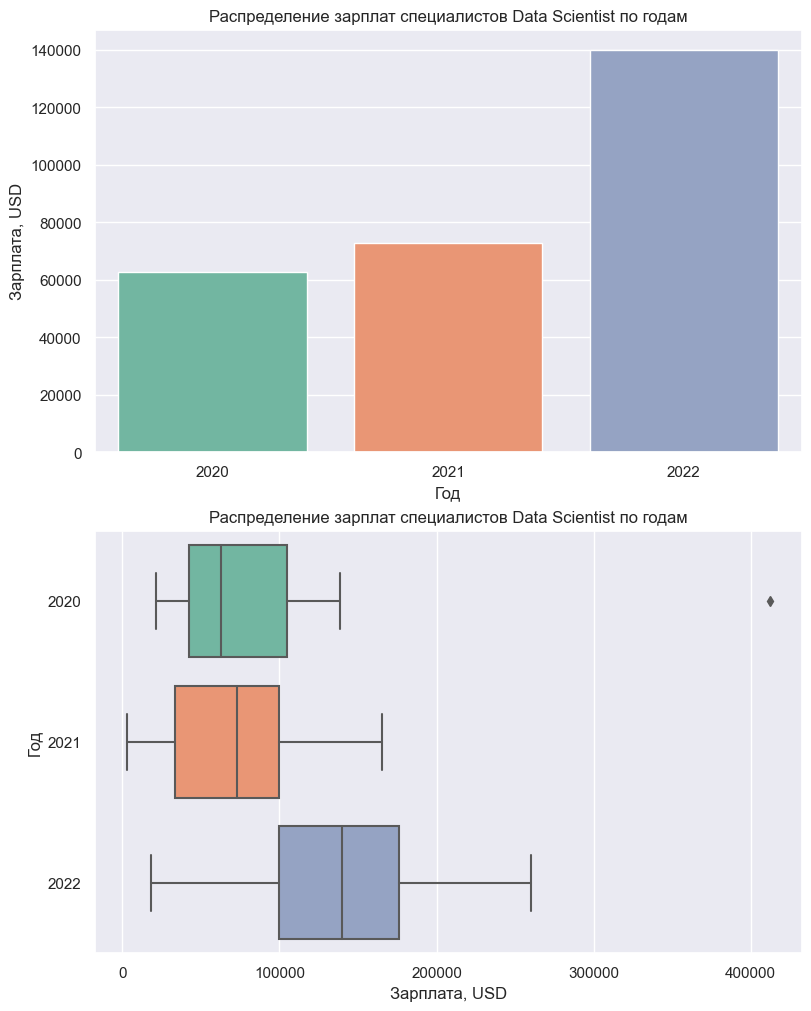

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)

df = data[(data['is_data_scientist'] == 1)].groupby('work_year', as_index=False)['salary_in_usd'].median()

h1 = sns.barplot(
    data=df,
    x='work_year',
    y='salary_in_usd',
    ax=axes[0]
).set(
    title='Распределение зарплат специалистов Data Scientist по годам', 
    xlabel='Год',
    ylabel='Зарплата, USD',
)

h2 = sns.boxplot(
    data=data[(data['is_data_scientist'] == 1)],
    y='work_year',
    x='salary_in_usd',
    ax=axes[1]
).set(
    title='Распределение зарплат специалистов Data Scientist по годам', 
    xlabel='Зарплата, USD', 
    ylabel='Год',
)

plt.show()

Выводы: 
* визуально наблюдается ежегодный рост медианной зарплаты у специалистов Data Scientist
* можно утверждать, что рост медианной зарплаты в 2022 году по сравнению с предыдущими годами вырос значимо (подвердим это про помощи статистических тестов ниже)
* рост медианной зарплаты в 2021 году по сравнению с 2020 годом, скорее всего, вырос не значимо

### Распределение зарплат у специалистов Data Scientist и Data Engineer в 2022 году

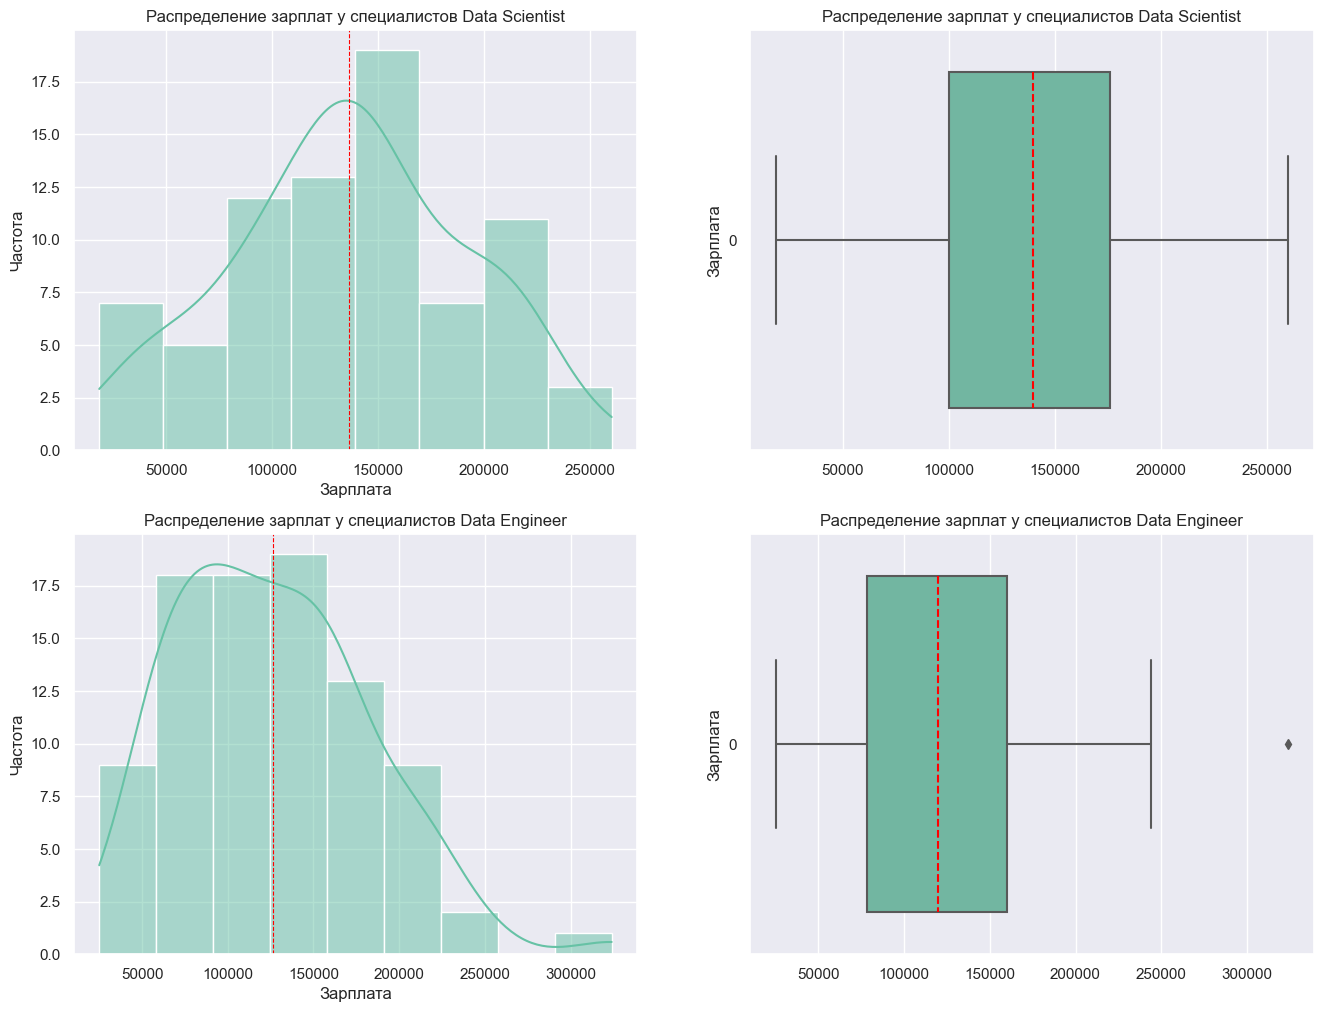

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

df_scientist = data[(data['is_data_scientist'] == 1) & (data['work_year'] == 2022)]['salary_in_usd'].reset_index(drop=True)

sns.histplot(df_scientist, kde=True, ax=axes[0][0])
axes[0][0].set(xlabel='Зарплата', ylabel='Частота')
axes[0][0].set_title('Распределение зарплат у специалистов Data Scientist')
axes[0][0].axvline(df_scientist.mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df_scientist, ax=axes[0][1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[0][1].set(ylabel='Зарплата')
axes[0][1].set_title('Распределение зарплат у специалистов Data Scientist')

df_engineer = data[(data['is_data_engineer'] == 1) & (data['work_year'] == 2022)]['salary_in_usd'].reset_index(drop=True)

sns.histplot(df_engineer, kde=True, ax=axes[1][0])
axes[1][0].set(xlabel='Зарплата', ylabel='Частота')
axes[1][0].set_title('Распределение зарплат у специалистов Data Engineer')
axes[1][0].axvline(df_engineer.mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df_engineer, ax=axes[1][1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1][1].set(ylabel='Зарплата')
axes[1][1].set_title('Распределение зарплат у специалистов Data Engineer')

plt.show()

Выводы: 
* наблюдается выброс для позиции Data Engineer
* распределение зарплат Data Scientist и Data Engineer близко к нормально, но это утверждение надо проверить тестами на нормальность
* визуально зарплата специалиста Data Scientist больше, чем у Data Engineer, но является это утверждение статистически значимым или нет, проверим в статистическом анализе данных

### Зарплаты специалистов Data Scientist в зависимости от размеров компании

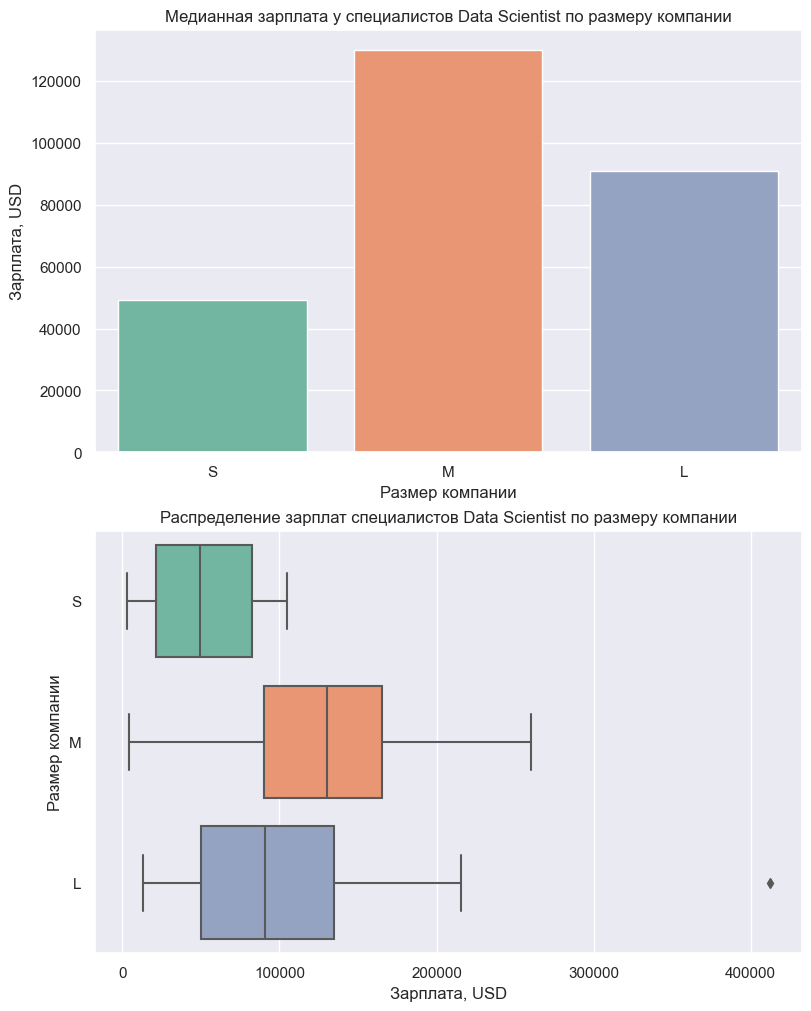

In [86]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)

df = data[(data['is_data_scientist'] == 1)].groupby('company_size', as_index=False)['salary_in_usd'].median()

h1 = sns.barplot(
    data=df,
    x='company_size',
    y='salary_in_usd',
    ax=axes[0]
).set(
    title='Медианная зарплата у специалистов Data Scientist по размеру компании',
    xlabel='Размер компании', 
    ylabel='Зарплата, USD', 
)

h2 = sns.boxplot(
    data=data[(data['is_data_scientist'] == 1)],
    y='company_size',
    x='salary_in_usd',
    ax=axes[1]
).set(
    title='Распределение зарплат специалистов Data Scientist по размеру компании', 
    xlabel='Зарплата, USD', 
    ylabel='Размер компании',
)

plt.show()

Вывод: на первый взгляд зарплаты зависят от размеров компании: меньше платят в маленьких компаниях, а больше - в средних. Чтобы определить, являются ли эти различия статистически значимыми, проведём статистическое тестирование в статистическом анализе данных.

### Количество вакансий Data Scientist и Data Engineer в зависимости от размеров компании

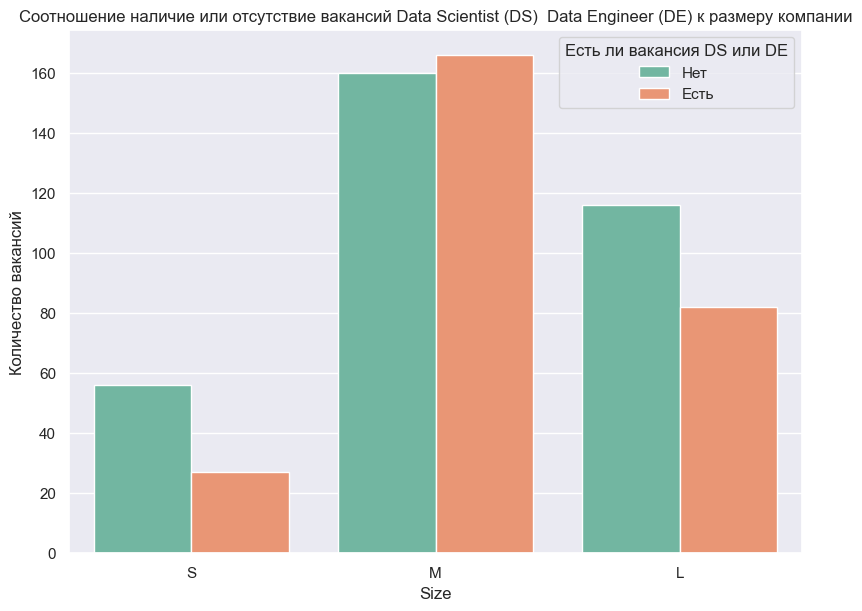

In [87]:
df = data.copy()
df['has_ds_or_de'] = df.apply(lambda x: x['is_data_scientist'] == 1 or x['is_data_engineer'] == 1, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

sns.countplot(data=df, x=data['company_size'], hue='has_ds_or_de', ax=ax)
ax.set(xlabel='Size', ylabel='Количество вакансий')

plt.title('Соотношение наличие или отсутствие вакансий Data Scientist (DS)  Data Engineer (DE) к размеру компании')
plt.legend(labels=['Нет', 'Есть'], title="Есть ли вакансия DS или DE")
plt.show()


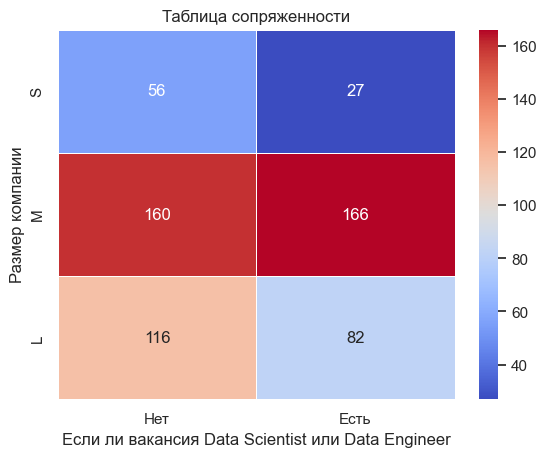

In [88]:
cross_tab = pd.crosstab(index=df['company_size'], columns=df['has_ds_or_de'])
cross_tab.columns = ['Нет', 'Есть']

ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Если ли вакансия Data Scientist или Data Engineer', ylabel='Размер компании')

plt.title('Таблица сопряженности')
plt.show()

Выводы: визуально не видно никакой зависимости от наличия или отсутствия вакансий Data Scientist или Data Engineer и размером компании.

### Дополнение 1: Зарплата вакансии Data Scientist в зависимости от опыта

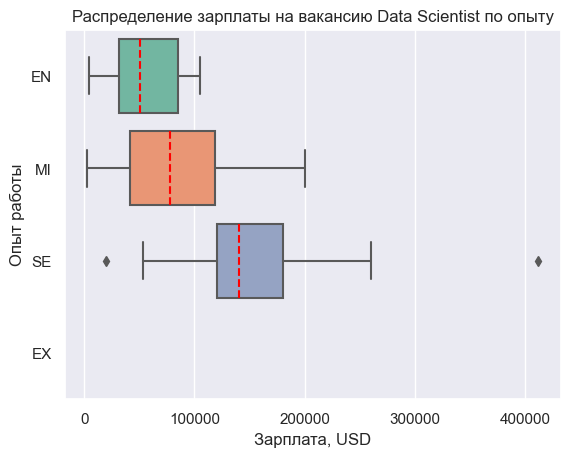

In [89]:
df = data[data['is_data_scientist'] == 1]

ax = sns.boxplot(data=df, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, USD', ylabel='Опыт работы')

plt.title('Распределение зарплаты на вакансию Data Scientist по опыту')
plt.show()

count        61.000000
mean     152971.016393
std       58985.402166
min       20171.000000
25%      120000.000000
50%      140400.000000
75%      180000.000000
max      412000.000000
Name: salary_in_usd, dtype: float64

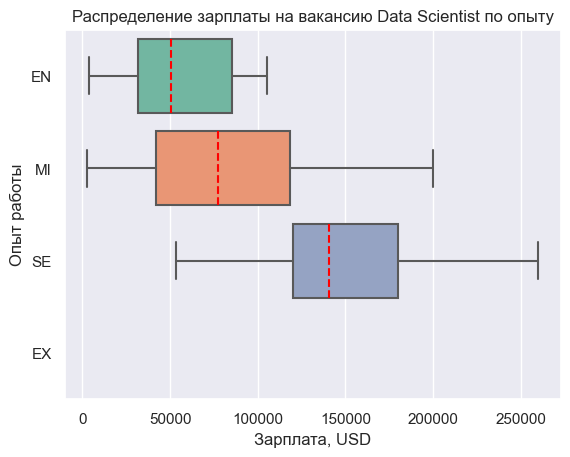

In [90]:
# удалим два выброса для вакансий с опытом Senior
df = data[(data['is_data_scientist'] == 1) & ((data['experience_level'] == 'EN') | (data['experience_level'] == 'MI') | (data['experience_level'] == 'SE'))]

# находим мин. и мах. значение для вакансий с опытом Senior
display(df[(df['experience_level'] == 'SE')]['salary_in_usd'].describe())

# удаляем две записи
df = df.drop(df[(df['experience_level'] == 'SE') & ((df['salary_in_usd'] == 20171) | (df['salary_in_usd'] == 412000))].index)

ax = sns.boxplot(data=df, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, USD', ylabel='Опыт работы')

plt.title('Распределение зарплаты на вакансию Data Scientist по опыту')
plt.show()


Выводы: 
* визуально зарплата Data Scientist зависит от опыта: чем больше опыта, тем выше зарплата. Не смотря на то, что это очевидный факт во всех областях, проверим является ли это утверждение для вакансии Data Scientist
* нет данных по опыту EX, поскольку должность Data Scientist не является директорской
* есть два выброса по зарплате по опыту SE - удалим их позже и только в том случае, если они будут влиять на результаты тестов

### Дополнение 2: Зарплата вакансии Data Scientist в зависимости от валюты получения

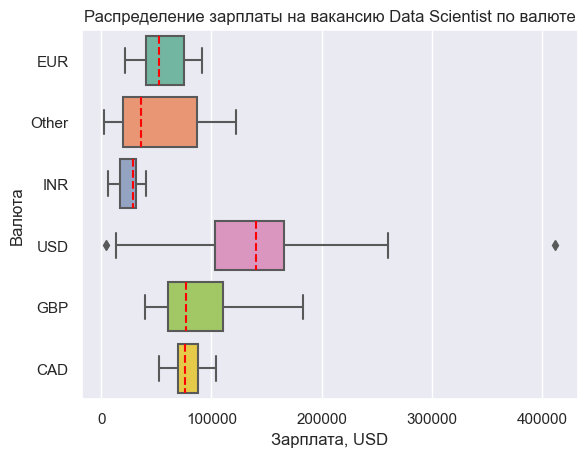

,count,mean,std,min,25%,50%,75%,max
currency,,,,,,,,
CAD,5.0,77787.00,19301.65,52396.0,69336.00,75774.0,87738.0,103691.0
EUR,22.0,57591.68,21531.70,21669.0,40486.25,52256.5,75370.0,91237.0
GBP,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.0,183228.0
INR,9.0,23838.33,11758.72,5679.0,16904.00,28399.0,31615.0,40481.0
Other,9.0,52822.44,45107.18,2859.0,20171.00,35735.0,86703.0,122346.0
USD,87.0,139712.76,58519.74,4000.0,103495.00,140000.0,166110.0,412000.0


In [91]:
df = data[data['is_data_scientist'] == 1].copy()

# новый столбец для валюты групирует вместе остальные валюты не входящие в топ 5 
df['currency'] = df['salary_currency'].apply(lambda x: x if x in ['USD', 'GBP', 'EUR', 'CAD', 'INR'] else 'Other')

ax = sns.boxplot(data=df, x='salary_in_usd', y='currency', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата, USD', ylabel='Валюта')

plt.title('Распределение зарплаты на вакансию Data Scientist по валюте')
plt.show()

data_agg = df.groupby('currency')['salary_in_usd'].describe().round(2)
data_agg

Вывод: распределения зарплат различны для разных валют. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [92]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты в 2022 году ($μ_1$) статистически меньше либо равно размеру зарплате в 2021 году ($μ_2$), что в свою очерень статистически меньше либо равно размеру зарплаты в 2021 году ($μ_3$).

$$ H_0 : μ_1 <= μ_2 <= μ_3 $$

*Альтернативная гипотеза* ($H_1$): размер зарплаты в 2022 году ($μ_1$) статистически больше, чем размер зарплаты в 2021 году ($μ_2$), что в свою очередь статистически больше размеру зарплаты в 2020 году ($μ_3$).

$$ H_1 : μ_1 > μ_2 > μ_3 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [93]:
df = data[data['is_data_scientist'] == 1]

# значения зарплаты вакансии Data Scientist
salary_2020 = df.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = df.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = df.loc[data['work_year']==2022, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])


Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела-Уоллиса для сравнения средних на основе рангов.

**Проведём тест**

In [94]:
# проводим тест
H0 = 'Нулевая гипотеза: медианы зарплат в 2020 году (m1), в 2021 году (m2) и 2022 году (m3) равны.'
H1 = 'Альтернативная гипотеза: медианы зарплат в 2020 году (m1), в 2021 году (m2) и 2022 году (m3) не равны.'

# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**
К сожалению критерий Краскела-Уоллиса говорит нам лишь о том, что зарплаты в 2020, 2021 и 2022 годах статистически значимо отличаются, поэтому проведем несколько дополнительных тестов, которые должны подтвердить рост зарплат.

**Выберем подходящий статистический тест для зарплат из 2020 и 2021 годов**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [95]:
H0 = 'Нулевая гипотеза: медиана зарплат в 2020 году (m1) не отличается от медианы зарплат в 2021 году (m2).'
H1 = 'Альтернативная гипотеза: медианы зарплат в 2020 году (m1) отличается от медианы зарплат в 2021 году (m2).'

_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.640
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод** 
Не было статистически значемых изменений в зарплатах 2020 и 2021 годов

**Выберем подходящий статистический тест для зарплат 2021 и 2022 годов**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий

**Проведём тест**

In [96]:
H0 = 'Нулевая гипотеза: средняя зарплаа в 2021 году (m1) больше или равна средней зарплаты в 2022 году (m2).'
H1 = 'Альтернативная гипотеза: средняя зарплата в 2021 году (m1) меньше средней зарплаты в 2022 году (m2).'

# Прежде чем использовать двухвыборочный t-критерий, необходимо провести
# тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
_, p = stats.levene(salary_2021, salary_2022)
print('p-value = {:.3f}'.format(p))
if p < alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
    
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_2021, salary_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.445
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод
Отвечая на вопрос "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?", можно ответить, что ежегодный рост зарплат у специалистов Data Scientist вырос к 2022 году, а 2021 году статистически значимых изменений по сравнению с 2020 году не произошли.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
Поскольку визульано зарплаты Data Scientist выше зарплат Data Engineer в 2022 году, попробуем проверить является ли это нераверство статистически значимым.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist ($μ_1$) статистически меньше либо равна зарплате Data Engineer в 2022 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): зарплата Data Scientist ($μ_1$) статистически больше, чем зарплата Data Engineer в 2022 году ($μ_2$).
$$ H_1 : μ_1 > μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [97]:
# значения зарплаты вакансии Data Scientist
ds_salary_2022 = data[data['is_data_scientist'] == 1].loc[data['work_year']==2022, 'salary_in_usd']

# значения зарплаты вакансии Data Engineer
de_salary_2022 = data[data['is_data_engineer'] == 1].loc[data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(ds_salary_2022)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(de_salary_2022)
decision_normality(result[1])

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [98]:
# проводим тест
_, p = stats.mannwhitneyu(ds_salary_2022, de_salary_2022, alternative='greater')
decision_hypothesis(p)

p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [99]:
# проведем двухсторонний тест U-критерий Манна — Уитни, чтобы подтвердить, что зарплаты статистически не отличаются
_, p = stats.mannwhitneyu(ds_salary_2022, de_salary_2022, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод

Таким образом, не смотря на то, что медиана зарплат Data Scientist больше медианы зарплат Data Engineer в 2022 году, это различие статистически не значимо.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплаты специалистов Data Scientist не отличается в компаниях различных размеров: S - маленьких ($μ_1$), M - средних ($μ_2$), L - больших ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: зарплаты специалистов Data Scientist отличается в компаниях различных размеровх: S - маленьких ($μ_1$), M - средних ($μ_2$), L - больших ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [100]:
# значения страховых выплат
salary_s = data.loc[data['company_size']=='S', 'salary_in_usd']
salary_m = data.loc[data['company_size']=='M', 'salary_in_usd']
salary_l = data.loc[data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для маленьких компаний:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Для средних компаний:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Для больших компаний:')
result = stats.shapiro(salary_l)
decision_normality(result[1])


Для маленьких компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средних компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для больших компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [101]:
# проводим тест
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Зарплаты статистически отличаются в компаниях разных размеров. Сравним их попарно используя U-критерий Манна — Уитни.
Визуально у нас заплаты распледеляются так (для компаний: S - маленьких ($μ_1$),  L - больших ($μ_3$) и M - средних ($μ_2$)):

$$ μ_1 < μ_3 < μ_2 $$

Это будут у нас альтернативные гипотезы для каждой пары. А нулевые гипотезы для каждой пары будут следующие:

$$ μ_1 >= μ_3 >= μ_2 $$


In [102]:

print('Для пары: S и L:')
_, p = stats.mannwhitneyu(salary_s, salary_l, alternative='less')
decision_hypothesis(p)

print('Для пары: S и M:')
_, p = stats.mannwhitneyu(salary_s, salary_m, alternative='less')
decision_hypothesis(p)

print('Для пары: L и M:')
_, p = stats.mannwhitneyu(salary_l, salary_m, alternative='less')
decision_hypothesis(p)

print('Для пары: L и M проведем еще и двух-сторонний тест, чтобы доказать статистически незначимые различия в зарплатах:')
_, p = stats.mannwhitneyu(salary_l, salary_m, alternative='two-sided')
decision_hypothesis(p)

Для пары: S и L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Для пары: S и M:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
Для пары: L и M:
p-value = 0.108
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
Для пары: L и M проведем еще и двух-сторонний тест, чтобы доказать статистически незначимые различия в зарплатах:
p-value = 0.216
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод

Таким образом, зарплаты специалистов Data Scientist в маленьких компаниях стистически меньше зарплат этих же специалистов в больших и средних компаний. Не смотря на то, что медианная зарплата выше в средних компаниях по сравнению с бошими компаниями, это различие статистически не значимо.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, есть ли наличием должностей Data Scientist и Data Engineer, и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, есть ли наличием должностей Data Scientist и Data Engineer, и размером компании есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [103]:
df = data.copy()
df['has_ds_or_de'] = df.apply(lambda x: x['is_data_scientist'] == 1 or x['is_data_engineer'] == 1, axis=1)

cross_tab = pd.crosstab(index=df['company_size'], columns=df['has_ds_or_de'])
display(cross_tab)

has_ds_or_de,False,True
company_size,,
S,56,27
M,160,166
L,116,82


In [104]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод

Наличием должностей Data Scientist и Data Engineer, и размеры компании, скорее всего, связаны. А каким образом связаны, я затрудняюсь ответить - по таблице сопряженности ничего не могу сказать. Возможно, требуются еще тесты, о которых я не знаю.

### Дополнение 1: Как соотносятся зарплаты Data Scientist в зависимости от опыта

Очевидно, что опыт влияет на зарплату в любых сферах - чем больше опыта, тем выше зарплата. Проверим, является ли эта разница для вакансии Data Scientist статистически значимой.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплаты специалистов Data Scientist с разным опыто не отличаются: EN - Entry-level/Junior ($μ_1$), MI - Mid-level/Intermediate ($μ_2$), SE - Senior-level/Expert ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: зарплаты специалистов Data Scientist с разным опыто отличаются: EN - Entry-level/Junior ($μ_1$), MI - Mid-level/Intermediate ($μ_2$), SE - Senior-level/Expert ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

In [105]:
# выбираем специалистов Data Scientist с опытами EN, MI и SE
df = data[(data['is_data_scientist'] == 1) & ((data['experience_level'] == 'EN') | (data['experience_level'] == 'MI') | (data['experience_level'] == 'SE'))]

# находим две записи-выбросы для опыта SE (из секции EDA) - минимальное и максимальное, и удаляем их
display(df.groupby('experience_level')['salary_in_usd'].describe())
df = df.drop(df[(df['experience_level'] == 'SE') & ((df['salary_in_usd'] == 20171) | (df['salary_in_usd'] == 412000))].index)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.909091,31237.823453,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.133333,46869.579661,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.016393,58985.402166,20171.0,120000.0,140400.0,180000.00,412000.0
EX,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

Сперва проверим на данных с выбросами (интересно, влияют ли выбросы на результаты):

In [106]:
# значения страховых выплат
salary_en = data.loc[data['experience_level']=='EN', 'salary_in_usd']
salary_mi = data.loc[data['experience_level']=='MI', 'salary_in_usd']
salary_se = data.loc[data['experience_level']=='SE', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Entry-level/Junior:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для Mid-level/Intermediate:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Для Senior-level/Expert:')
result = stats.shapiro(salary_se)
decision_normality(result[1])


Для Entry-level/Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Mid-level/Intermediate:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Senior-level/Expert:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


А теперь на данных без выбросов:

In [107]:
# значения страховых выплат
salary_en = df.loc[df['experience_level']=='EN', 'salary_in_usd']
salary_mi = df.loc[df['experience_level']=='MI', 'salary_in_usd']
salary_se = df.loc[df['experience_level']=='SE', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Entry-level/Junior:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для Mid-level/Intermediate:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Для Senior-level/Expert:')
result = stats.shapiro(salary_se)
decision_normality(result[1])


Для Entry-level/Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Mid-level/Intermediate:
p-value = 0.178
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Senior-level/Expert:
p-value = 0.309
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Вывод**

Выбросы влияют на результаты теста, поэтому дальше работаем с данными, где выбросы были исключены.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать Однофакторный дисперсионный анализ (ANOVA).

**Проведём тест**

In [108]:
# но сначала проверим выбырки на равенство дисперсий

print('Тест на равенство дисперсий')
result = stats.levene(salary_en, salary_mi, salary_se)
p = result[1]
print('p-value = {:.3f}'.format(p))
# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних (ANOVA)')
_, p = stats.f_oneway(salary_en, salary_mi, salary_se)
decision_hypothesis(p)


Тест на равенство дисперсий
p-value = 0.128
Дисперсии одинаковы, мы можем использовать тест ANOVA

Тест на равенство средних (ANOVA)
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**

Зарплаты статистически отличаются от опыта. 

Сравним их попарно используя двух выборочный t-критерий (поскольку зарплаты для всех уровней опыта распределены нормально).

Визуально у нас заплаты распледеляются так (для компаний: EN - Entry-level/Junior ($μ_1$),  MI - Mid-level/Intermediate ($μ_2$) и SE - Senior-level/Expert ($μ_3$)):

$$ μ_1 < μ_2 < μ_3 $$

Это будут у нас альтернативные гипотезы для каждой пары. 

А нулевые гипотезы для каждой пары будут следующие:

$$ μ_1 >= μ_2 >= μ_3 $$


- пара EN/MI

In [109]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
_, p = stats.levene(salary_en, salary_mi)
print('p-value = {:.3f}'.format(p))
if p < alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
    
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_en, salary_mi, alternative='less', equal_var=False)
decision_hypothesis(p)
    

Тест на равенство дисперсий
p-value = 0.029
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


- пара MI/SE

In [110]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
_, p = stats.levene(salary_mi, salary_se)
print('p-value = {:.3f}'.format(p))
if p < alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')
    
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(salary_mi, salary_se, alternative='less', equal_var=True)
decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.653
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Вывод
Сюрпризов не произошло. Зарплата по вакансии Data Scientist статистически зависит от опыта. Чем больше опыт, тем выше зарплата.

### Дополнение 2: Как соотносятся зарплаты Data Scientist в зависимости от валюты получения

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплаты специалистов Data Scientist с разной валютой не отличаются: USD ($μ_1$), GBP ($μ_2$), EUR ($μ_2$), CAD ($μ_4$), INR ($μ_5$), Other ($μ_6$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6$$

*Альтернативная гипотеза*: зарплаты специалистов Data Scientist с разной валютой отличаются: USD ($μ_1$), GBP ($μ_2$), EUR ($μ_2$), CAD ($μ_4$), INR ($μ_5$), Other ($μ_6$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [111]:
df = data[data['is_data_scientist'] == 1].copy()

# новый столбец для валюты групирует вместе остальные валюты не входящие в топ 5 
df['currency'] = df['salary_currency'].apply(lambda x: x if x in ['USD', 'GBP', 'EUR', 'CAD', 'INR'] else 'Other')

# зарплаты для каждой валюты
salary_usd = df.loc[df['currency']=='USD', 'salary_in_usd']
salary_gbp = df.loc[df['currency']=='GBP', 'salary_in_usd']
salary_eur = df.loc[df['currency']=='EUR', 'salary_in_usd']
salary_cad = df.loc[df['currency']=='CAD', 'salary_in_usd']
salary_inr = df.loc[df['currency']=='INR', 'salary_in_usd']
salary_other = df.loc[df['currency']=='Other', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для USD:')
result = stats.shapiro(salary_usd)
decision_normality(result[1])

print('Для GBP:')
result = stats.shapiro(salary_gbp)
decision_normality(result[1])

print('Для EUR:')
result = stats.shapiro(salary_eur)
decision_normality(result[1])

print('Для CAD:')
result = stats.shapiro(salary_cad)
decision_normality(result[1])

print('Для INR:')
result = stats.shapiro(salary_inr)
decision_normality(result[1])

print('Для Other:')
result = stats.shapiro(salary_other)
decision_normality(result[1])

Для USD:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для GBP:
p-value = 0.277
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для EUR:
p-value = 0.187
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для CAD:
p-value = 0.997
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для INR:
p-value = 0.661
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Other:
p-value = 0.098
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Шесть.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [112]:
_, p = stats.kruskal(salary_usd, salary_gbp, salary_eur, salary_cad, salary_inr, salary_other)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Промежуточный вывод**
Зарплаты специалистов Data Scientist статистически значимо отличаются. Проверим, больше ли зарплата у лидера (USD) по сравнению со 2-м местом (GBP).

**Сформулируем нулевую и альтернативные гипотезы**
*Нулевая гипотеза*: зарплаты специалистов Data Scientist с валютой USD меньше или разва зарплате с валютой GBP: USD ($μ_1$), GBP ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза*: зарплаты специалистов Data Scientist с валютой USD меньше или разва зарплате с валютой GBP: USD ($μ_1$), GBP ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [113]:
_, p = stats.mannwhitneyu(salary_usd, salary_gbp, alternative="greater")
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**
Зарплата специалистов Data Scientist с валютой USD больше по сравнению с зарплатами специалистов Data Scientist в других валютах.

## Итоговые результаты исследования

В результате исследования получили ответы на следующие вопросы:

1. _Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?_

   Ежегодный рост зарплат у специалистов Data Scientist вырос к 2022 году, а 2021 году статистически значимых изменений по сравнению с 2020 году не произошли.

2. _Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?_
   Не смотря на то, что медиана зарплат Data Scientist больше медианы зарплат Data Engineer в 2022 году, это различие статистически не значимо, то есть нет основания отверждать, что зарплаты Data Scientist и Data Engineer в 2022 году значимо отличаются.
   

3. _Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?_
   * Зарплаты специалистов Data Scientist в маленьких компаниях стистически меньше зарплат этих же специалистов в больших и средних компаний. 
   * Зарплаты специалистов Data Scientist в средних компаниях по сравнению с зарплатами в большими компаниями статистически не отличаются.<p></p>

4. _Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?_
   Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании

### Дополнительно получили:
* зарплата по вакансии Data Scientist статистически зависит от опыта. Чем больше опыт, тем выше зарплата.
* зарплата специалистов Data Scientist с валютой USD больше по сравнению с зарплатами специалистов Data Scientist в других валютах.